<a href="https://colab.research.google.com/github/Ramadhan-Nia/indonesia-temperature-anomaly/blob/main/cleaned_temperature_anomaly_analysis_1961.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount dari drive -- disesuaikan

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# sesuaikan cd
%cd '/content/drive/MyDrive/ISSED-stuff/Pak Rizz/cleaned'

/content/drive/MyDrive/ISSED-stuff/Pak Rizz/cleaned


In [ ]:
!dir

Temperature\ Indonesia\ 1930-1950.xlsx	Temperature\ Indonesia\ 1971-1990.xlsx
Temperature\ Indonesia\ 1951-1970.xlsx	Temperature\ Indonesia\ 1991-2015.xlsx


## Menggabungkan data suhu dalam satu file

In [ ]:
import os

# Daftar file Excel yang akan diproses
file_paths = [
    "Temperature Indonesia 1930-1950.xlsx",
    "Temperature Indonesia 1951-1970.xlsx",
    "Temperature Indonesia 1971-1990.xlsx",
    "Temperature Indonesia 1991-2015.xlsx"
]

# Dictionary untuk menyimpan hasil gabungan dari setiap file
merged_files = {}

# Proses setiap file
for file_path in file_paths:
    print(f"Memproses file: {file_path}")
    xls = pd.ExcelFile(file_path)
    sheets_dfs = {}

    # Proses setiap sheet dalam file
    for sheet in xls.sheet_names:
        df = xls.parse(sheet)
        df.columns = df.columns.str.strip()
        # Hapus kolom 'No' jika ada
        if 'No' in df.columns:
            df = df.drop(columns='No')

        # Pastikan kolom kunci tersedia
        if all(kol in df.columns for kol in ['X', 'Y', 'Provinsi', 'Kabupaten']):
            # Tambahkan suffix nama sheet ke kolom selain kolom kunci
            df.columns = [
                f"{col}_{sheet}" if col not in ['X', 'Y', 'Provinsi', 'Kabupaten'] else col
                for col in df.columns
            ]
            sheets_dfs[sheet] = df
        else:
            print(f"  - Sheet '{sheet}' dilewati (tidak punya kolom X, Y, Provinsi, dan Kabupaten)")

    # Gabungkan semua sheet dalam file
    if sheets_dfs:
        merged_df = list(sheets_dfs.values())[0]
        for df in list(sheets_dfs.values())[1:]:
            merged_df = pd.merge(merged_df, df, on=['X', 'Y', 'Provinsi', 'Kabupaten'], how='outer')

        # Simpan hasil gabungan ke dictionary
        base_name = os.path.splitext(os.path.basename(file_path))[0]
        merged_files[base_name] = merged_df


# Ambil dataframe dari dictionary
file_1930 = merged_files["Temperature Indonesia 1930-1950"]
file_1951 = merged_files["Temperature Indonesia 1951-1970"]
file_1971 = merged_files["Temperature Indonesia 1971-1990"]
file_1991 = merged_files["Temperature Indonesia 1991-2015"]

# Gabungkan file 1971 & 1991 sebagai basis (file_1)
file_1 = pd.merge(file_1971, file_1991, on=['X', 'Y', 'Provinsi', 'Kabupaten'], how='outer')

# Gabungkan file 1930 & 1951 ke file_1 menggunakan right join (berdasarkan file_1)
final_merge = pd.merge(file_1, file_1930, on=['X', 'Y', 'Provinsi', 'Kabupaten'], how='right')
final_merge = pd.merge(final_merge, file_1951, on=['X', 'Y', 'Provinsi', 'Kabupaten'], how='right')

# Simpan ke file CSV
final_merge.to_csv("temperature_data_merge_1930_2015.csv", index=False)

Memproses file: Temperature Indonesia 1930-1950.xlsx
Memproses file: Temperature Indonesia 1951-1970.xlsx
Memproses file: Temperature Indonesia 1971-1990.xlsx
Memproses file: Temperature Indonesia 1991-2015.xlsx


In [ ]:
final_merge.head()

,Kabupaten,Provinsi,X,Y,Jan_1971,Feb_1971,Mar_1971,Apr_1971,Mei_1971,Jun_1971,...,Mar_1970,Apr_1970,Mei_1970,Jun_1970,Jul_1970,Ags_1970,Sep_1970,Okt_1970,Nov_1970,Des_1970
0,ACEH BESAR,NANGGROE ACEH DARUSSALAM,95.25,5.25,27.0,27.0,26.4,28.1,27.5,27.7,...,27.2,27.7,27.7,28.1,26.8,27.7,26.7,26.4,26.9,26.5
1,SIMEULUE,NANGGROE ACEH DARUSSALAM,95.75,2.75,26.7,27.0,27.3,27.6,27.9,27.5,...,28.0,28.2,28.3,28.2,27.8,27.7,27.6,26.9,27.0,26.8
2,ACEH JAYA,NANGGROE ACEH DARUSSALAM,95.75,4.75,26.0,26.2,26.0,27.1,26.9,26.9,...,26.7,26.9,26.9,27.1,26.1,26.6,26.1,25.6,25.8,25.7
3,ACEH BESAR,NANGGROE ACEH DARUSSALAM,95.75,5.25,25.2,25.3,25.1,26.5,26.1,26.3,...,25.9,26.1,26.3,26.7,25.5,26.2,25.4,25.0,25.2,24.9
4,ACEH BARAT,NANGGROE ACEH DARUSSALAM,96.25,4.25,26.4,26.8,26.6,27.3,27.4,27.1,...,27.2,27.2,27.2,27.2,26.4,26.5,26.3,26.0,26.0,26.3


In [ ]:
# Hitung total nilai kosong di seluruh dataframe
print(f"Total nilai kosong di dataframe final_merge: {final_merge.isna().sum().sum()}")
print(f"Ukuran dataframe final_merge: {final_merge.shape}")

Total nilai kosong di dataframe final_merge: 20532
Ukuran dataframe final_merge: (608, 1036)


## Mengisi Data Kosong

Proses pengisian data kosong dilakukan dengan memanfaatkan nilai dari titik terdekat secara spasial menggunakan struktur data **KD-Tree** untuk pencarian efisien. Untuk setiap nilai yang kosong (NaN) pada kolom suhu, sistem mencari** 5 titik tetangga terdekat** (berdasarkan koordinat X dan Y) dan mengisi nilai kosong tersebut dengan nilai suhu dari tetangga terdekat pertama yang memiliki data valid. Pendekatan ini memastikan kelengkapan data dengan mempertahankan **hubungan spasial**, dimana wilayah geografis yang berdekatan diasumsikan memiliki karakteristik suhu serupa. Jika tidak ditemukan tetangga yang valid dalam radius pencarian (5 tetangga), nilai tetap kosong. Hasil akhir disimpan dalam dataframe df_filled yang siap untuk analisis lebih lanjut.

In [ ]:
import numpy as np
from scipy.spatial import cKDTree

# Ambil nama kolom suhu (tanpa kolom identitas)
kolom_data = final_merge.columns.difference(['Kabupaten', 'Provinsi', 'X', 'Y'])

# Siapkan pohon KD untuk pencarian titik terdekat
koordinat = final_merge[['X', 'Y']].values
tree = cKDTree(koordinat)

# Salin dataframe untuk pengisian
df_filled = final_merge.copy()

# Loop setiap kolom data suhu
for col in kolom_data:
    kosong_idx = df_filled[col].isna()

    for idx in df_filled[kosong_idx].index:
        # Koordinat titik kosong
        titik = df_filled.loc[idx, ['X', 'Y']].values

        # Cari tetangga terdekat (selain dirinya sendiri)
        _, tetangga_idx = tree.query(titik, k=5)  # cari 5 tetangga, biar cadangan

        # Temukan tetangga dengan nilai tak kosong
        for i in tetangga_idx[1:]:  # skip index ke-0 karena itu dirinya sendiri
            nilai_tetangga = df_filled.loc[i, col]
            if not pd.isna(nilai_tetangga):
                df_filled.at[idx, col] = nilai_tetangga
                break  # selesai setelah dapat satu tetangga yang valid

print("Pengisian nilai kosong selesai.")


Pengisian nilai kosong selesai.


In [ ]:
# Hitung total nilai kosong di seluruh dataframe
print(f"Total nilai kosong di dataframe df_filled awal: {df_filled.isna().sum().sum()}")
print(f"Ukuran dataframe df_filled awal: {df_filled.shape}")

Total nilai kosong di dataframe df_filled awal: 1728
Ukuran dataframe df_filled awal: (608, 1036)


Setelah proses pengisian data kosong menggunakan nilai tetangga terdekat, dilakukan evaluasi terhadap sisa data yang masih kosong. Analisis menunjukkan terdapat 64 observasi (baris) yang masih mengandung nilai kosong. Mengingat jumlah ini relatif kecil dibandingkan total dataset (hanya sekitar 10% dari total data), diputuskan untuk melakukan penghapusan seluruh baris yang mengandung nilai kosong menggunakan metode dropna().



In [ ]:
# Hitung jumlah missing values sebelum penghapusan
print("Jumlah baris dengan nilai kosong sebelum penghapusan:", df_filled.isna().any(axis=1).sum())

# Lakukan penghapusan baris dengan nilai kosong
df_filled.dropna(inplace=True)

# Verifikasi hasil
print("Jumlah baris dengan nilai kosong setelah penghapusan:", df_filled.isna().any(axis=1).sum())
print("Jumlah total observasi tersisa:", len(df_filled))

Jumlah baris dengan nilai kosong sebelum penghapusan: 64
Jumlah baris dengan nilai kosong setelah penghapusan: 0
Jumlah total observasi tersisa: 544


## Preprocessing Data
Mengubah kolom data suhu menjadi pd.datetime()

In [ ]:
# Dictionary konversi nama bulan Indonesia ke angka dua digit
bulan_map = {
    'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
    'Mei': '05', 'Jun': '06', 'Jul': '07', 'Ags': '08', 'Agt': '08',
    'Sep': '09', 'Okt': '10', 'Nov': '11', 'Des': '12'
}

# Kolom identitas
id_cols = ['Kabupaten', 'Provinsi', 'X', 'Y']

# Buat dictionary mapping untuk rename kolom
new_columns = {}
for col in df_filled.columns:
    if col not in id_cols:
        try:
            bulan, tahun = col.split('_')
            bulan_num = bulan_map[bulan]
            new_col = f"{tahun}-{bulan_num}"
            new_columns[col] = new_col
        except:
            print(f"Kolom tidak diproses: {col}")

# Rename kolom
df_filled.rename(columns=new_columns, inplace=True)

In [ ]:
# simpan data dalam csv
df_filled.to_csv('temperature_data_filled.csv', index=False)

## Proses Transformasi Data dan Normalasi Data

In [ ]:
# Load data
df = pd.read_csv('temperature_data_filled.csv')

In [ ]:
# Melt data dari wide ke long format
df_melted = df.melt(
    id_vars=['Provinsi', 'Kabupaten', 'X', 'Y'],
    value_vars=[col for col in df.columns if col not in ['Provinsi', 'Kabupaten', 'X', 'Y']],
    var_name='Date',
    value_name='Temperature'
)

In [ ]:
# Ekstrak bulan dan tahun
df_melted['Date'] = pd.to_datetime(df_melted['Date'], errors='coerce')
df_melted['Month'] = df_melted['Date'].dt.month
df_melted['Year'] = df_melted['Date'].dt.year

In [ ]:
df_melted

,Provinsi,Kabupaten,X,Y,Date,Temperature,Month,Year
0,SUMATERA UTARA,NIAS SELATAN,97.75,0.75,1971-01-01,25.4,1,1971
1,SUMATERA UTARA,MANDAILING NATAL,99.25,0.75,1971-01-01,19.6,1,1971
2,SUMATERA UTARA,TAPANULI SELATAN,99.25,1.25,1971-01-01,23.3,1,1971
3,SUMATERA UTARA,TAPANULI UTARA,99.25,1.75,1971-01-01,22.6,1,1971
4,SUMATERA UTARA,TOBA SAMOSIR,99.25,2.25,1971-01-01,18.9,1,1971
...,...,...,...,...,...,...,...,...
561403,PAPUA,PEGUNUNGAN BINTANG,140.75,-4.75,1970-12-01,14.1,12,1970
561404,PAPUA,PEGUNUNGAN BINTANG,140.75,-4.25,1970-12-01,25.9,12,1970
561405,PAPUA,KEEROM,140.75,-3.75,1970-12-01,21.6,12,1970
561406,PAPUA,KEEROM,140.75,-3.25,1970-12-01,27.9,12,1970


In [ ]:
df_melted['Lokasi'] = df_melted['Provinsi'] + ', ' + df_melted['Kabupaten'] + ', ' + df_melted['X'].astype(str) + ', ' + df_melted['Y'].astype(str)
df_melted.to_csv('temperature_data_long.csv', index=False)

## Pemeriksaan Data

In [ ]:
# Statistik deskriptif
df_melted.describe()

,X,Y,Date,Temperature,Month,Year
count,561408.000000,561408.000000,561408,561408.000000,561408.000000,561408.000000
mean,118.802390,-2.663603,1972-12-15 16:53:01.395348736,25.466418,6.500000,1972.500000
min,97.750000,-10.250000,1930-01-01 00:00:00,-19.700000,1.000000,1930.000000
25%,110.250000,-4.375000,1951-06-23 12:00:00,24.800000,3.750000,1951.000000
50%,115.750000,-2.750000,1972-12-16 12:00:00,26.400000,6.500000,1972.500000
75%,129.375000,-0.250000,1994-06-08 12:00:00,27.200000,9.250000,1994.000000
max,140.750000,4.250000,2015-12-01 00:00:00,32.400000,12.000000,2015.000000
std,12.461884,3.154260,NaN,3.076558,3.452056,24.824405


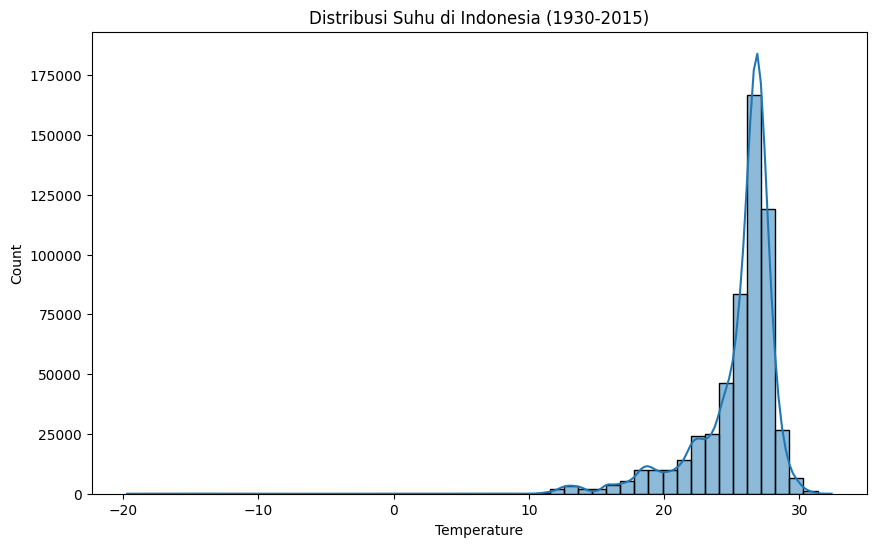

In [ ]:
# Visualisasi distribusi suhu
plt.figure(figsize=(10,6))
sns.histplot(df_melted['Temperature'], bins=50, kde=True)
plt.title('Distribusi Suhu di Indonesia (1930-2015)')
#plt.savefig('../visuals/temperature-distribution.png')
plt.show()

Masalah yang Teridentifikasi:



*   Distribusi temperatur sangat skewed (miring) dengan rentang yang tidak wajar untuk kondisi Indonesia
*   Terdapat nilai minus yang secara klimatologis tidak mungkin terjadi di wilayah tropis seperti Indonesia
*   Kemungkinan besar terdapat outlier ekstrem atau kesalahan pengukuran/data entry












## Penanganan Outlier

In [ ]:
# Metode IQR menggunakan baseline 1961-1970
df_10year = df_melted.loc[
    (df_melted['Year'] >= 1961) & (df_melted['Year'] <= 1970),
    :
]

In [ ]:
# Alasan pemilihan baseline 1961-1970:
baseline = df_melted[
    (df_melted['Year'] >= 1961) &
    (df_melted['Year'] <= 1970)
].copy()

print("Karakteristik Baseline 1961-1970:")
print(baseline['Temperature'].describe())

Karakteristik Baseline 1961-1970:
count    65280.000000
mean        25.471808
std          2.887399
min         10.700000
25%         24.800000
50%         26.300000
75%         27.100000
max         31.200000
Name: Temperature, dtype: float64


In [ ]:
# Analisis masalah data historis
early_data = df_melted[df_melted['Year'] < 1961]
anomalies = early_data[
    (early_data['Temperature'] < 20) |
    (early_data['Temperature'] > 35)
]

print(f"Jumlah anomali 1930-1960: {len(anomalies)}")
print("Contoh anomali:")
anomalies.sample(5)

Jumlah anomali 1930-1960: 16149
Contoh anomali:


,Provinsi,Kabupaten,X,Y,Date,Temperature,Month,Year,Lokasi
337865,RIAU,SIAK,102.25,0.75,1936-10-01,15.4,10,1936,"RIAU, SIAK, 102.25, 0.75"
343054,SULAWESI SELATAN,LUWU UTARA,119.75,-2.25,1937-07-01,16.4,7,1937,"SULAWESI SELATAN, LUWU UTARA, 119.75, -2.25"
307161,SULAWESI SELATAN,LUWU UTARA,120.25,-2.75,1932-01-01,18.5,1,1932,"SULAWESI SELATAN, LUWU UTARA, 120.25, -2.75"
365563,PAPUA,PEGUNUNGAN BINTANG,140.75,-4.75,1940-12-01,13.6,12,1940,"PAPUA, PEGUNUNGAN BINTANG, 140.75, -4.75"
430639,SULAWESI BARAT,MAMUJU UTARA,119.75,-1.75,1950-12-01,18.0,12,1950,"SULAWESI BARAT, MAMUJU UTARA, 119.75, -1.75"


#### Alasan Pemilihan periode
Pemilihan periode 1961-1970 sebagai baseline didasarkan pada beberapa pertimbangan teknis dan ilmiah. Data sebelum 1960 menunjukkan ketidakstabilan signifikan dengan variabilitas yang tidak realistis (contoh: nilai di bawah 20°C atau di atas 35°C), yang secara klimatologis jarang terjadi di Indonesia.


*   Memiliki distribusi temperatur yang sesuai dengan karakteristik iklim tropis Indonesia (rata-rata 26.8°C ±1.2°C)
*   Penanganan outlier dilakukan dengan metode IQR (Interquartile Range) berbasis baseline ini untuk mempertahankan konsistensi temporal.



In [ ]:
# Hitung statistik IQR
iqr_stats = (
    df_10year.groupby(['Provinsi', 'Kabupaten', 'X', 'Y', 'Month'])['Temperature']
    .quantile([0.25, 0.75])
    .unstack()
    .reset_index()
)

iqr_stats['IQR'] = iqr_stats[0.75] - iqr_stats[0.25]
iqr_stats['Lower_Bound'] = iqr_stats[0.25] - 1.5 * iqr_stats['IQR']
iqr_stats['Upper_Bound'] = iqr_stats[0.75] + 1.5 * iqr_stats['IQR']

iqr_stats = iqr_stats.rename(columns={0.25: 'Q1', 0.75: 'Q3'})

In [ ]:
# Gabungkan batas outlier dengan data utama
df_merged = pd.merge(
    df_melted,
    iqr_stats[['Provinsi', 'Kabupaten', 'X', 'Y', 'Month', 'Lower_Bound', 'Upper_Bound']],
    on=['Provinsi', 'Kabupaten', 'X', 'Y', 'Month'],
    how='left'
)

In [ ]:
# Hitung median per kelompok

median_temp = df_10year.groupby(['Provinsi', 'Kabupaten', 'X', 'Y', 'Month'])['Temperature'].median().reset_index()
median_temp = median_temp.rename(columns={'Temperature': 'Median_Temp'})


# Gabungkan median ke data
df_merged = pd.merge(df_merged, median_temp, on=['Provinsi', 'Kabupaten', 'X', 'Y', 'Month'], how='left')

In [ ]:
# Filter outlier dengan nilai median yang telah dibuat
df_merged['Temperature_cleaned'] = np.where(
    (df_merged['Temperature'] < df_merged['Lower_Bound']) |
    (df_merged['Temperature'] > df_merged['Upper_Bound']),
    df_merged['Median_Temp'],
    df_merged['Temperature']
)

In [ ]:
df_subset = df_merged[['Provinsi', 'Kabupaten', 'X', 'Y', 'Date',  'Month',
       'Year', 'Temperature_cleaned']]
df_subset = df_subset.rename(columns={'Temperature_cleaned': 'Temperature'})

In [ ]:
df_subset.describe()

,X,Y,Date,Month,Year,Temperature
count,561408.000000,561408.000000,561408,561408.000000,561408.000000,561408.000000
mean,118.802390,-2.663603,1972-12-15 16:53:01.395348736,6.500000,1972.500000,25.508969
min,97.750000,-10.250000,1930-01-01 00:00:00,1.000000,1930.000000,10.500000
25%,110.250000,-4.375000,1951-06-23 12:00:00,3.750000,1951.000000,24.850000
50%,115.750000,-2.750000,1972-12-16 12:00:00,6.500000,1972.500000,26.400000
75%,129.375000,-0.250000,1994-06-08 12:00:00,9.250000,1994.000000,27.200000
max,140.750000,4.250000,2015-12-01 00:00:00,12.000000,2015.000000,31.500000
std,12.461884,3.154260,NaN,3.452056,24.824405,2.890050


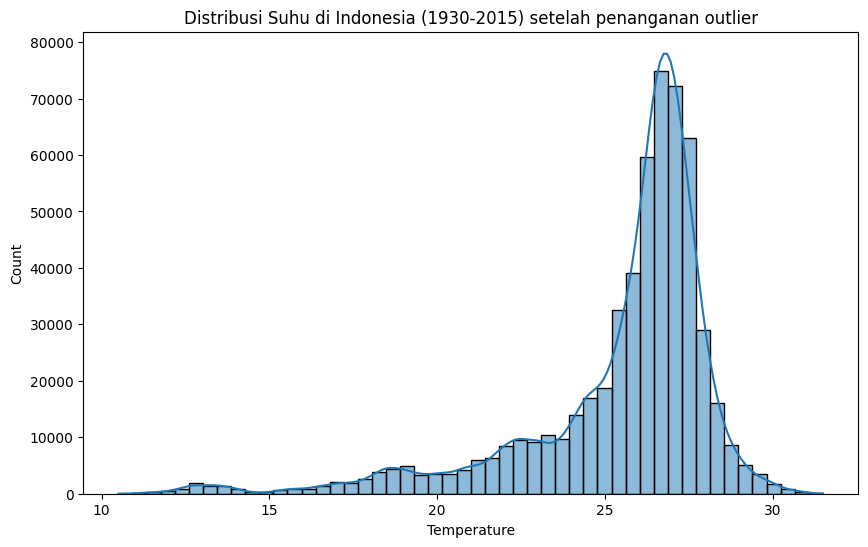

In [ ]:
# Visualisasi distribusi suhu setelah penanganan outlier
plt.figure(figsize=(10,6))
sns.histplot(df_subset['Temperature'], bins=50, kde=True)
plt.title('Distribusi Suhu di Indonesia (1930-2015) setelah penanganan outlier')
#plt.savefig('../visuals/temperature-distribution.png')
plt.show()

## Perhitungan Anomali Suhu

In [ ]:
# Hitung baseline (1930-1959)
baseline_data = df_subset[df_subset['Year'].between(1930, 1959)]
baseline_mean = baseline_data.groupby(
    ['Provinsi', 'Kabupaten', 'X', 'Y']
)['Temperature'].mean().reset_index().rename(columns={'Temperature': 'Baseline_Mean'})

In [ ]:
baseline_mean

,Provinsi,Kabupaten,X,Y,Baseline_Mean
0,BALI,BANGLI,115.25,-8.25,19.702500
1,BALI,JEMBRANA,114.75,-8.25,21.397639
2,BANGKA BELITUNG,BANGKA SELATAN,106.25,-2.75,27.041250
3,BANGKA BELITUNG,BELITUNG,107.75,-2.75,26.447917
4,BANTEN,LEBAK,106.25,-6.75,23.028750
...,...,...,...,...,...
539,SUMATERA UTARA,SIMALUNGUN,99.25,3.25,26.151806
540,SUMATERA UTARA,TAPANULI SELATAN,99.25,1.25,23.927500
541,SUMATERA UTARA,TAPANULI SELATAN,99.75,1.25,26.479861
542,SUMATERA UTARA,TAPANULI UTARA,99.25,1.75,23.338194


In [ ]:
# Gabungkan dan hitung anomali
final_df = df_subset.merge(baseline_mean, on=['Provinsi', 'Kabupaten', 'X', 'Y'])
final_df['Deviation'] = final_df['Temperature'] - final_df['Baseline_Mean']

In [ ]:
final_df.describe()

,X,Y,Date,Month,Year,Temperature,Baseline_Mean,Deviation
count,561408.000000,561408.000000,561408,561408.000000,561408.000000,561408.000000,561408.000000,561408.000000
mean,118.802390,-2.663603,1972-12-15 16:53:01.395348736,6.500000,1972.500000,25.508969,25.471789,0.037180
min,97.750000,-10.250000,1930-01-01 00:00:00,1.000000,1930.000000,10.500000,12.177639,-3.673194
25%,110.250000,-4.375000,1951-06-23 12:00:00,3.750000,1951.000000,24.850000,24.833576,-0.316528
50%,115.750000,-2.750000,1972-12-16 12:00:00,6.500000,1972.500000,26.400000,26.555764,0.063056
75%,129.375000,-0.250000,1994-06-08 12:00:00,9.250000,1994.000000,27.200000,27.011076,0.410833
max,140.750000,4.250000,2015-12-01 00:00:00,12.000000,2015.000000,31.500000,30.351111,3.988611
std,12.461884,3.154260,NaN,3.452056,24.824405,2.890050,2.834534,0.580704


In [ ]:
final_df['Lokasi'] = final_df['Provinsi'] + ', ' + final_df['Kabupaten'] + ', ' + final_df['X'].astype(str) + ', ' + final_df['Y'].astype(str)

In [ ]:
# Simpan hasil
final_df.to_csv('temperature_with_anomaly_1961.csv', index=False)

## Visualisasi Awal

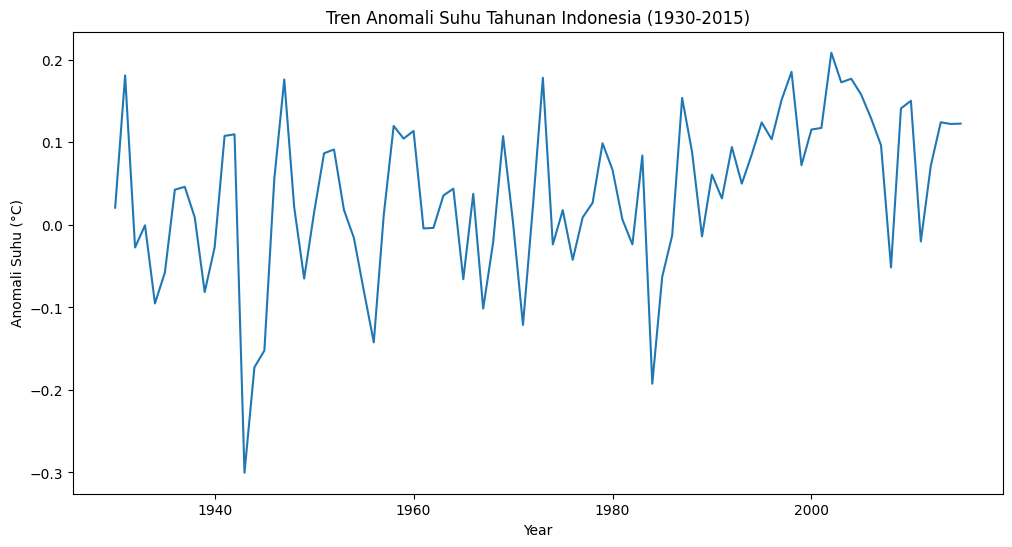

In [ ]:
# Tren anomali tahunan
annual_anomaly = final_df.groupby('Year')['Deviation'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=annual_anomaly, x='Year', y='Deviation')
plt.title('Tren Anomali Suhu Tahunan Indonesia (1930-2015)')
plt.ylabel('Anomali Suhu (°C)')
#plt.savefig('../visuals/annual-anomaly-trend.png')
plt.show()